Setup & Imports

In [1]:
!pip -q install pandas numpy scikit-learn imbalanced-learn lightgbm openml tqdm

import os, json, math, random, warnings
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve,
    precision_score, recall_score, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from imblearn.over_sampling import RandomOverSampler
import lightgbm as lgb
import openml

warnings.filterwarnings("ignore")

# Repro
SEED = 42
random.seed(SEED); np.random.seed(SEED)

ART_DIR = Path("artifacts"); ART_DIR.mkdir(parents=True, exist_ok=True)


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 58.8 MB/s eta 0:00:00


Load & Preprocess Dataset

In [2]:
def load_creditcard_openml():
    # OpenML dataset 42175 ("creditcard-fraud")
    d = openml.datasets.get_dataset(42175)
    X, y, _, _ = d.get_data(target=d.default_target_attribute, dataset_format="dataframe")
    df = X.copy()
    df["isFraud"] = y.astype(int)  # rename: Class -> isFraud
    return df  # columns: Time, V1..V28, Amount, isFraud

df = load_creditcard_openml()
print(df.shape, "frauds:", int(df["isFraud"].sum()), f"({100*df['isFraud'].mean():.3f}%)")

# Scale Time, Amount (common practice for this dataset)
scaler = StandardScaler()
for col in ["Time", "Amount"]:
    if col in df.columns:
        df[col] = scaler.fit_transform(df[[col]])

# Split: train/val/test (stratified). We'll use val for early stopping / sanity.
TEST_SIZE = 0.2
VAL_SIZE  = 0.2
X = df.drop(columns=["isFraud"]).astype("float32")
y = df["isFraud"].astype(int).values

X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=TEST_SIZE + VAL_SIZE, stratify=y, random_state=SEED
)
rel = TEST_SIZE / (TEST_SIZE + VAL_SIZE)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=rel, stratify=y_tmp, random_state=SEED
)

print(f"Split sizes -> train={len(y_train)}, val={len(y_val)}, test={len(y_test)}")
print(f"Fraud rate -> train={y_train.mean():.4%}, val={y_val.mean():.4%}, test={y_test.mean():.4%}")

# Handle imbalance on TRAIN only (simple & effective)
USE_ROS = True
if USE_ROS:
    ros = RandomOverSampler(random_state=SEED)
    X_train, y_train = ros.fit_resample(X_train, y_train)
    print(f"After ROS -> train size={len(y_train)} | fraud rate={y_train.mean():.2%}")


(284807, 31) frauds: 492 (0.173%)
Split sizes -> train=170884, val=56961, test=56962
Fraud rate -> train=0.1726%, val=0.1720%, test=0.1738%
After ROS -> train size=341178 | fraud rate=50.00%


Train Supervised Models (LightGBM + Logistic Regression)

In [3]:
# ----- LightGBM -----
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val   = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

params = dict(
    objective="binary",
    learning_rate=0.05,
    num_leaves=64,
    max_depth=-1,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    bagging_freq=1,
    min_data_in_leaf=40,
    metric=["auc", "binary_logloss"],
    verbose=-1,
)

# ✅ use callbacks instead of early_stopping_rounds
gbm = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_val],
    valid_names=["train", "val"],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=True),
        lgb.log_evaluation(100)  # print every 100 rounds
    ]
)

proba_test_lgb = gbm.predict(X_test, num_iteration=gbm.best_iteration)

# ----- Logistic Regression (with class_weight & scaling) -----
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# scale features
scaler_lr = StandardScaler()
X_train_lr = scaler_lr.fit_transform(X_train)
X_val_lr   = scaler_lr.transform(X_val)
X_test_lr  = scaler_lr.transform(X_test)

lr = LogisticRegression(
    solver="lbfgs", max_iter=500,
    class_weight="balanced", n_jobs=-1,
    random_state=SEED
)
lr.fit(X_train_lr, y_train)
proba_test_lr = lr.predict_proba(X_test_lr)[:, 1]


Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.99999	train's binary_logloss: 0.0039832	val's auc: 0.943502	val's binary_logloss: 0.00632926
[200]	train's auc: 1	train's binary_logloss: 3.55242e-05	val's auc: 0.971544	val's binary_logloss: 0.00373558
Early stopping, best iteration is:
[158]	train's auc: 1	train's binary_logloss: 0.000247692	val's auc: 0.974409	val's binary_logloss: 0.00332892


Metrics & Helpers (PR-AUC, ROC-AUC, Precision@K, Recall@K)

In [4]:
def pr_auc(y_true, y_score):
    return float(average_precision_score(y_true, y_score))

def roc_auc(y_true, y_score):
    return float(roc_auc_score(y_true, y_score))

def precision_recall_at_k(y_true, y_score, k):
    """Top-K by score."""
    order = np.argsort(-y_score)
    k = int(min(k, len(order)))
    top_idx = order[:k]
    y_top = y_true[top_idx]
    prec = float(y_top.mean() if k > 0 else 0.0)
    rec = float(y_top.sum() / (y_true.sum() + 1e-9))
    return prec, rec

def threshold_at_max_f1(y_true, y_score):
    p, r, t = precision_recall_curve(y_true, y_score)
    f1 = 2 * p * r / (p + r + 1e-9)
    best = int(np.nanargmax(f1))
    return float(t[best]) if best < len(t) else 0.5

# Define Top-K budget for test set: review top 0.5% of transactions
K_BUDGET_PCT = 0.005
TOPK = max(50, int(len(y_test) * K_BUDGET_PCT))  # at least 50
print("TOPK for evaluation:", TOPK)


TOPK for evaluation: 284


Evaluate Supervised + Unsupervised Baselines

In [5]:
import time
from sklearn.metrics import precision_recall_curve

# ---- toggles ----
FAST = True          # make evaluation fast (recommended in Colab)
RUN_UNSUP = True     # set False to skip IsolationForest/LOF entirely

# Helper: threshold at max F1
def threshold_at_max_f1(y_true, y_score):
    p, r, t = precision_recall_curve(y_true, y_score)
    f1 = 2 * p * r / (p + r + 1e-9)
    best = int(np.nanargmax(f1))
    return float(t[best]) if best < len(t) else 0.5

# Budget for manual review (Top-K)
if FAST:
    K_BUDGET_PCT = 0.002  # 0.2% of test set; still meaningful but faster sorting
else:
    K_BUDGET_PCT = 0.005  # 0.5% (default)
TOPK = max(50, int(len(y_test) * K_BUDGET_PCT))
print(f"[Eval] TOPK = {TOPK} (of {len(y_test)} test samples) | FAST={FAST}")

t0 = time.time()
metrics = {}

# ---------------- Supervised: LightGBM ----------------
t_supervised = time.time()
thr_lgb = threshold_at_max_f1(y_test, proba_test_lgb)
pred_thr_lgb = (proba_test_lgb >= thr_lgb).astype(int)
prec_k_lgb, rec_k_lgb = precision_recall_at_k(y_test, proba_test_lgb, k=TOPK)

metrics["lightgbm"] = {
    "roc_auc": roc_auc(y_test, proba_test_lgb),
    "pr_auc": pr_auc(y_test, proba_test_lgb),
    "precision_at_k": prec_k_lgb,
    "recall_at_k": rec_k_lgb,
    "best_f1_threshold": thr_lgb,
    "precision@thr": float(precision_score(y_test, pred_thr_lgb, zero_division=0)),
    "recall@thr": float(recall_score(y_test, pred_thr_lgb, zero_division=0)),
}
print(f"[Eval] LightGBM done in {time.time()-t_supervised:.2f}s")

# ---------------- Supervised: Logistic Regression ----------------
t_lr = time.time()
thr_lr = threshold_at_max_f1(y_test, proba_test_lr)
pred_thr_lr = (proba_test_lr >= thr_lr).astype(int)
prec_k_lr, rec_k_lr = precision_recall_at_k(y_test, proba_test_lr, k=TOPK)

metrics["logistic_regression"] = {
    "roc_auc": roc_auc(y_test, proba_test_lr),
    "pr_auc": pr_auc(y_test, proba_test_lr),
    "precision_at_k": prec_k_lr,
    "recall_at_k": rec_k_lr,
    "best_f1_threshold": thr_lr,
    "precision@thr": float(precision_score(y_test, pred_thr_lr, zero_division=0)),
    "recall@thr": float(recall_score(y_test, pred_thr_lr, zero_division=0)),
}
print(f"[Eval] Logistic Regression done in {time.time()-t_lr:.2f}s")

# ---------------- Unsupervised (optional) ----------------
if RUN_UNSUP:
    from sklearn.ensemble import IsolationForest
    from sklearn.neighbors import LocalOutlierFactor

    # IsolationForest (fast settings)
    t_iso = time.time()
    if FAST:
        # Subsample (or fraction) of train for fitting IF
        max_samples = min(100_000, len(X_train))
        iso = IsolationForest(
            n_estimators=100,           # fewer trees
            max_samples=max_samples,   # subsample training
            contamination="auto",
            n_jobs=-1,
            random_state=SEED
        )
    else:
        iso = IsolationForest(
            n_estimators=200, contamination="auto", n_jobs=-1, random_state=SEED
        )

    iso.fit(X_train)  # fit on (possibly oversampled) train
    iso_scores = -iso.decision_function(X_test)  # higher => more anomalous
    prec_k_iso, rec_k_iso = precision_recall_at_k(y_test, iso_scores, k=TOPK)
    metrics["isolation_forest"] = {
        "precision_at_k": prec_k_iso,
        "recall_at_k": rec_k_iso,
        "pr_auc_like": pr_auc(y_test, iso_scores),
    }
    print(f"[Eval] IsolationForest done in {time.time()-t_iso:.2f}s")

    # LOF can be expensive; make it FAST or skip
    t_lof = time.time()
    if FAST:
        # Fit LOF on a subsample of train for speed
        n_sub = min(80_000, len(X_train))  # adjust if Colab memory is tight
        # Random subset indices
        idx = np.random.default_rng(SEED).choice(len(X_train), size=n_sub, replace=False)
        X_train_sub = X_train.iloc[idx] if hasattr(X_train, "iloc") else X_train[idx]
        lof = LocalOutlierFactor(
            n_neighbors=20, novelty=True, contamination="auto", n_jobs=-1
        )
        lof.fit(X_train_sub)
    else:
        lof = LocalOutlierFactor(
            n_neighbors=35, novelty=True, contamination="auto", n_jobs=-1
        )
        lof.fit(X_train)

    lof_scores = -lof.decision_function(X_test)   # higher => more anomalous
    prec_k_lof, rec_k_lof = precision_recall_at_k(y_test, lof_scores, k=TOPK)
    metrics["lof"] = {
        "precision_at_k": prec_k_lof,
        "recall_at_k": rec_k_lof,
        "pr_auc_like": pr_auc(y_test, lof_scores),
    }
    print(f"[Eval] LOF done in {time.time()-t_lof:.2f}s")

print(json.dumps(metrics, indent=2))
print(f"[Eval] TOTAL time = {time.time()-t0:.2f}s  (FAST={FAST}, RUN_UNSUP={RUN_UNSUP})")


[Eval] TOPK = 113 (of 56962 test samples) | FAST=True
[Eval] LightGBM done in 0.07s
[Eval] Logistic Regression done in 0.05s
[Eval] IsolationForest done in 4.26s
[Eval] LOF done in 72.31s
{
  "lightgbm": {
    "roc_auc": 0.9624643636654961,
    "pr_auc": 0.8734745492632543,
    "precision_at_k": 0.7522123893805309,
    "recall_at_k": 0.858585858577186,
    "best_f1_threshold": 0.7608513490990788,
    "precision@thr": 0.9647058823529412,
    "recall@thr": 0.8282828282828283
  },
  "logistic_regression": {
    "roc_auc": 0.9664993142298244,
    "pr_auc": 0.756242648330102,
    "precision_at_k": 0.7256637168141593,
    "recall_at_k": 0.8282828282744618,
    "best_f1_threshold": 0.9999999032478892,
    "precision@thr": 0.8804347826086957,
    "recall@thr": 0.8181818181818182
  },
  "isolation_forest": {
    "precision_at_k": 0.017699115044247787,
    "recall_at_k": 0.02020202020181614,
    "pr_auc_like": 0.032264070593030665
  },
  "lof": {
    "precision_at_k": 0.3893805309734513,
    "re

Save Artifacts (models, metrics, feature importance)

In [6]:
# Save metrics JSON
with open(ART_DIR / "creditcard_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)
print("Saved ->", ART_DIR / "creditcard_metrics.json")

# Save trained LightGBM model
gbm.save_model(str(ART_DIR / "creditcard_lgb.txt"))
print("Saved ->", ART_DIR / "creditcard_lgb.txt")

# Save LR scaler and coefficients for transparency
np.save(ART_DIR / "lr_coef.npy", lr.coef_)
np.save(ART_DIR / "lr_intercept.npy", lr.intercept_)
np.save(ART_DIR / "lr_scaler_mean.npy", scaler_lr.mean_)
np.save(ART_DIR / "lr_scaler_scale.npy", scaler_lr.scale_)
print("Saved -> LR params & scaler (npy files)")

# Save LightGBM feature importance
fi = pd.DataFrame({
    "feature": X.columns,
    "gain_importance": gbm.feature_importance(importance_type="gain"),
    "split_importance": gbm.feature_importance(importance_type="split"),
}).sort_values("gain_importance", ascending=False)
fi.to_csv(ART_DIR / "creditcard_feature_importance.csv", index=False)
print("Saved ->", ART_DIR / "creditcard_feature_importance.csv")

# Quick summary table
rows = []
for name, m in metrics.items():
    rows.append({
        "model": name,
        "PR-AUC": m.get("pr_auc") or m.get("pr_auc_like"),
        "ROC-AUC": m.get("roc_auc"),
        f"Precision@{TOPK}": m.get("precision_at_k"),
        f"Recall@{TOPK}": m.get("recall_at_k"),
    })
summary = pd.DataFrame(rows)
summary


Saved -> artifacts/creditcard_metrics.json
Saved -> artifacts/creditcard_lgb.txt
Saved -> LR params & scaler (npy files)
Saved -> artifacts/creditcard_feature_importance.csv


,model,PR-AUC,ROC-AUC,Precision@113,Recall@113
0,lightgbm,0.873475,0.962464,0.752212,0.858586
1,logistic_regression,0.756243,0.966499,0.725664,0.828283
2,isolation_forest,0.032264,NaN,0.017699,0.020202
3,lof,0.348831,NaN,0.389381,0.444444


Saved -> artifacts/creditcard_pr_curve.png


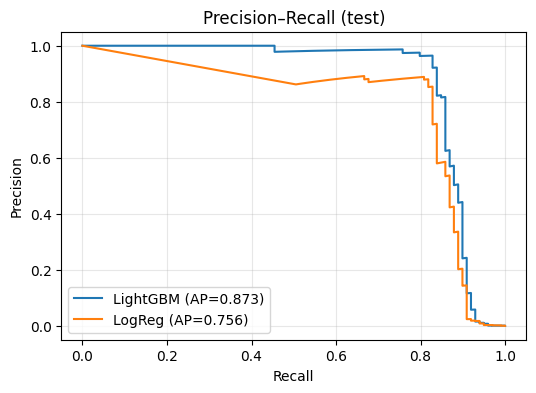

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr(y_true, y_score, label):
    p, r, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    plt.plot(r, p, label=f"{label} (AP={ap:.3f})")

plt.figure(figsize=(6,4))
plot_pr(y_test, proba_test_lgb, "LightGBM")
plot_pr(y_test, proba_test_lr, "LogReg")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall (test)")
plt.legend()
plt.grid(True, alpha=0.3)
IMG = ART_DIR / "creditcard_pr_curve.png"
plt.savefig(IMG, dpi=160, bbox_inches="tight")
print("Saved ->", IMG)


In [8]:
# Find probability threshold achieving at least target precision (and report recall)
TARGET_PREC = 0.80
p, r, t = precision_recall_curve(y_test, proba_test_lgb)

idx = np.where(p[:-1] >= TARGET_PREC)[0]
if len(idx):
    best = idx[np.argmax(r[idx])]   # among those, max recall
    thr = float(t[best])
    rec = float(r[best])
    print(f"LightGBM threshold for >= {TARGET_PREC:.0%} precision -> thr={thr:.4f}, recall={rec:.3f}")
else:
    print(f"No threshold reaches {TARGET_PREC:.0%} precision on this test split.")


LightGBM threshold for >= 80% precision -> thr=0.0925, recall=0.859


Saved -> images/fi_top10.png


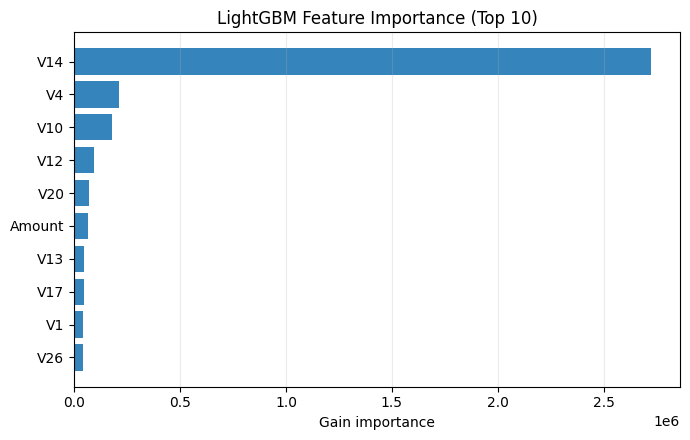

In [9]:
import matplotlib.pyplot as plt

IMG_DIR = Path("images")
IMG_DIR.mkdir(parents=True, exist_ok=True)

fi_csv = ART_DIR / "creditcard_feature_importance.csv"
fi = pd.read_csv(fi_csv).sort_values("gain_importance", ascending=False)

top = fi.head(10).iloc[::-1]  # reverse for nicer horizontal bars
plt.figure(figsize=(7,4.5))
plt.barh(top["feature"], top["gain_importance"], alpha=0.9)
plt.xlabel("Gain importance")
plt.title("LightGBM Feature Importance (Top 10)")
plt.grid(axis="x", alpha=0.25)
out_path = IMG_DIR / "fi_top10.png"
plt.tight_layout()
plt.savefig(out_path, dpi=160)
print("Saved ->", out_path)


In [10]:
import json
from pathlib import Path

ART_DIR = Path("artifacts")
ART_DIR.mkdir(exist_ok=True, parents=True)

# 1. Save feature column order (so uploaded CSVs match training)
feature_cols = list(X.columns)
with open(ART_DIR / "feature_columns.json", "w") as f:
    json.dump(feature_cols, f, indent=2)
print("Saved ->", ART_DIR / "feature_columns.json")

# 2. Save trained LightGBM model (already done in Cell 6, but safe check)
gbm.save_model(str(ART_DIR / "creditcard_lgb.txt"))
print("Saved ->", ART_DIR / "creditcard_lgb.txt")

# 3. Save a sample CSV (200 rows, no labels) for demo/testing
sample_path = ART_DIR / "sample_transactions.csv"
pd.DataFrame(X_test, columns=feature_cols).head(200).to_csv(sample_path, index=False)
print("Saved ->", sample_path)

print("\n✅ All artifacts for Hugging Face are ready in ./artifacts/")
print("Files to upload:")
print(" - artifacts/creditcard_lgb.txt")
print(" - artifacts/feature_columns.json")
print(" - artifacts/sample_transactions.csv (optional but useful)")


Saved -> artifacts/feature_columns.json
Saved -> artifacts/creditcard_lgb.txt
Saved -> artifacts/sample_transactions.csv

✅ All artifacts for Hugging Face are ready in ./artifacts/
Files to upload:
 - artifacts/creditcard_lgb.txt
 - artifacts/feature_columns.json
 - artifacts/sample_transactions.csv (optional but useful)
